In [63]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import sklearn
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.offline as pyoff
import xgboost as xgb
import seaborn as sns
from datetime import date
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc,roc_auc_score,accuracy_score,classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_predict
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
df = pd.read_csv('drive/My Drive/Projet-ML/data/df_condition.csv')
df=df.rename(columns={'CIMIS Region':'Region','Stn Name':'Name'})
#df=df[df.Name=='Fiv']

In [66]:
df['Target'].value_counts(dropna=True)

0.0    68835
1.0      944
Name: Target, dtype: int64

In [67]:
df.shape

(69780, 20)

In [68]:
df.tail(3)

,Unnamed: 0,Stn Id,Name,Region,Date,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),Target
69777,81021,2,FivePoints,San Joaquin Valley,8/24/2019,0.27,0.0,601.0,17.8,98.0,66.8,83.0,70.0,30.0,46.0,60.2,5.4,128.4,77.5,0.0
69778,81022,2,FivePoints,San Joaquin Valley,8/25/2019,0.26,0.0,551.0,16.3,99.0,68.3,84.7,61.0,27.0,40.0,57.8,5.2,125.7,77.8,0.0
69779,81023,2,FivePoints,San Joaquin Valley,8/26/2019,0.27,0.0,534.0,14.5,99.7,66.7,83.9,62.0,23.0,37.0,54.5,NaN,NaN,NaN,NaN


In [69]:
df['Region'].value_counts(dropna=True)

San Joaquin Valley              13305
Los Angeles Basin                6801
San Francisco Bay                6769
South Coast Valleys              6614
Monterey Bay                     6434
Sacramento Valley                6156
Imperial/Coachella Valley        5567
Central Coast Valleys            5342
North Coast Valleys              3330
Northeast Plateau                3237
San Bernardino                   2697
Sierra Foothill                  2692
Bishop                            782
Eastern Sierra Basin & Range       54
Name: Region, dtype: int64

In [70]:
df.set_index('Date', inplace=True)

In [71]:
df.drop(['Unnamed: 0', 'Stn Id', 'Name','Region'], axis=1, inplace=True)

In [72]:
df.head(10)

,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),Target
Date,,,,,,,,,,,,,,,
1/1/2018,0.06,0.00,219.0,7.3,63.4,35.3,47.8,82.0,46.0,65.0,36.6,3.3,78.3,51.1,0.0
1/2/2018,0.04,0.00,127.0,7.4,59.8,37.7,47.2,80.0,52.0,67.0,36.7,3.1,74.5,51.3,0.0
1/3/2018,0.04,0.00,125.0,8.4,61.1,37.3,49.9,79.0,49.0,68.0,39.9,4.5,107.5,51.3,0.0
1/4/2018,0.07,0.01,219.0,11.6,69.2,48.7,56.8,94.0,52.0,74.0,48.5,5.8,140.2,53.0,0.0
1/5/2018,0.07,0.00,239.0,12.7,73.8,47.5,59.8,94.0,49.0,72.0,50.8,4.2,101.4,54.4,0.0
1/6/2018,0.02,0.04,101.0,13.4,60.2,47.6,55.2,96.0,80.0,90.0,52.3,6.7,162.0,55.4,0.0
1/7/2018,0.06,0.00,202.0,11.6,65.7,50.9,56.4,90.0,58.0,74.0,48.4,3.5,83.3,55.5,0.0
1/8/2018,0.01,0.38,65.0,13.8,60.0,51.7,55.6,97.0,79.0,92.0,53.2,5.1,122.0,55.9,0.0
1/10/2018,0.05,0.00,259.0,10.7,59.3,46.6,54.1,94.0,60.0,75.0,46.3,5.7,137.6,56.2,0.0


In [73]:
df.Target.value_counts(dropna=False)

0.0    68835
1.0      944
NaN        1
Name: Target, dtype: int64

In [74]:
total = df.isnull().sum().sort_values(ascending=False)
# show
pd.DataFrame(data={'Missing': total})

,Missing
Target,1
Avg Soil Temp (F),1
Wind Run (miles),1
Avg Wind Speed (mph),1
Dew Point (F),0
Avg Rel Hum (%),0
Min Rel Hum (%),0
Max Rel Hum (%),0
Avg Air Temp (F),0
Min Air Temp (F),0


In [75]:
df['Target'].replace(np.nan,0,inplace=True)
df['Avg Soil Temp (F)']=df['Avg Soil Temp (F)'].fillna(df['Avg Soil Temp (F)'].mean())
df['Wind Run (miles)']=df['Wind Run (miles)'].fillna(df['Wind Run (miles)'].mean())
df['Avg Wind Speed (mph)']=df['Avg Wind Speed (mph)'].fillna(df['Avg Wind Speed (mph)'].mean())

In [76]:
descriptive= df.loc[:, df.columns != 'Target']
prediction=df['Target']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(descriptive,prediction, test_size=0.2)

In [78]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

## MON CODE 
params = {'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]}

folds = 4
param_comb = 3

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

clf = RandomizedSearchCV(xgb.XGBClassifier(learning_rate=0.02, n_estimators=300, objective='binary:logistic',
                  silent=True, nthread=1), param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# model
boost = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=2,
              learning_rate=0.02, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=None, n_estimators=300, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1.0, verbosity=1)

#train
boost.fit(X_train,y_train)
boost.proba = boost.predict_proba(X_test)
boost.proba = boost.proba[:,1]
boost.fpr, boost.tpr, boost.thresholds = roc_curve(y_test,boost.proba)
boost.auc = auc(boost.fpr,boost.tpr)
y_pred=boost.predict_proba(X_test)[:,1]
y_pred2=boost.predict(X_test)
print(roc_auc_score(y_test, y_pred))
print(accuracy_score(y_test,boost.predict(X_test)))
print(confusion_matrix(y_test,y_pred2))
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(boost.fpr,boost.tpr, color='red', label=f'{boost}: {boost.auc}')

KeyboardInterrupt: ignored

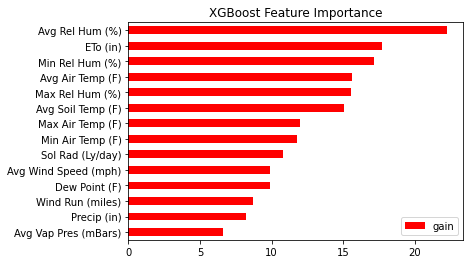

In [ ]:
feature_important = boost.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["gain"]).sort_values(by ="gain", ascending=True)
data.plot(kind='barh', color='r')
plt.title('XGBoost Feature Importance')
plt.show()

### REBALANCE DES CLASSES


### UPSAMPLE

In [79]:
from sklearn.utils import resample
# Upsample minority class
# Separate majority and minority classes
df_majority = df[df.Target==0]
df_minority = df[df.Target==1]
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=68836,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.Target.value_counts()

1.0    68836
0.0    68836
Name: Target, dtype: int64

In [80]:
y = df_upsampled.Target
X = df_upsampled.drop('Target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

Estimate: 1.000
0.9997745002164514
[[13398   272]
 [    0 13865]]
0.9901216633375703


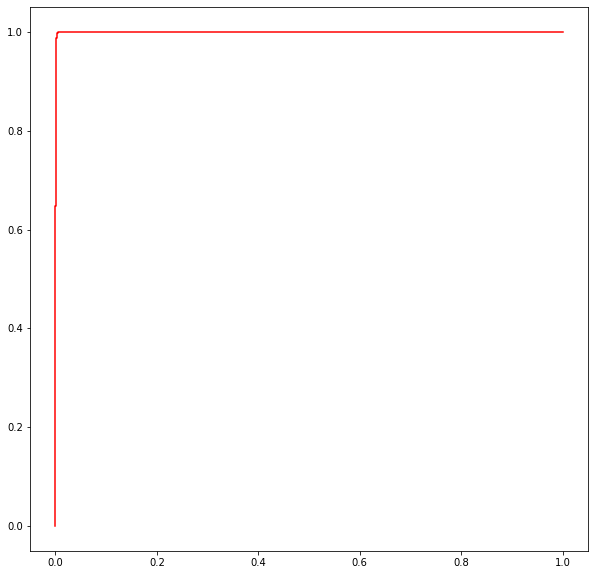

In [81]:
from collections import Counter
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)


params = {'max_depth': 10,
          'min_child_weight': 6,
          'n_estimators': 1000, 
          'learning_rate': 0.01,
          'lambda': 0.8,
          'alpha': 0.5}
boost2 = xgb.XGBClassifier(**params)#, scale_pos_weight=estimate)

boost2.fit(X_train, y_train)

boost2.proba = boost2.predict_proba(X_test)

boost2.proba = boost2.proba[:,1]

boost2.fpr, boost2.tpr, boost2.thresholds = roc_curve(y_test,boost2.proba)
boost2.auc = auc(boost2.fpr,boost2.tpr)

y_pred=boost2.predict_proba(X_test)[:,1]

print(roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test,boost2.predict(X_test)))
print(accuracy_score(y_test,boost2.predict(X_test)))
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(boost2.fpr,boost2.tpr, color='red', label=f'{boost2}: {boost2.auc}')

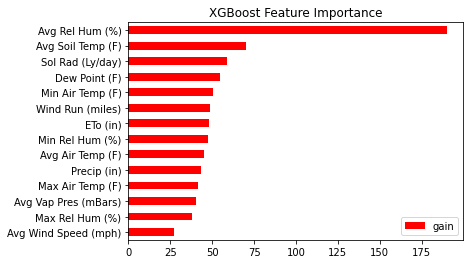

In [83]:
feature_important = boost2.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["gain"]).sort_values(by ="gain", ascending=True)
data.plot(kind='barh', color='r')
plt.title('XGBoost Feature Importance')
plt.show()

### DOWNSAMPLE

In [ ]:
# Separate majority and minority classes
df_majority = df[df.Target==0]
df_minority = df[df.Target==1]
print(df_majority.shape)
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=944,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.Target.value_counts()

In [ ]:
y = df_downsampled.Target
X = df_downsampled.drop('Target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

NameError: ignored

Estimate: 1.000
0.8686619816893916
[[149  42]
 [ 40 147]]
0.783068783068783


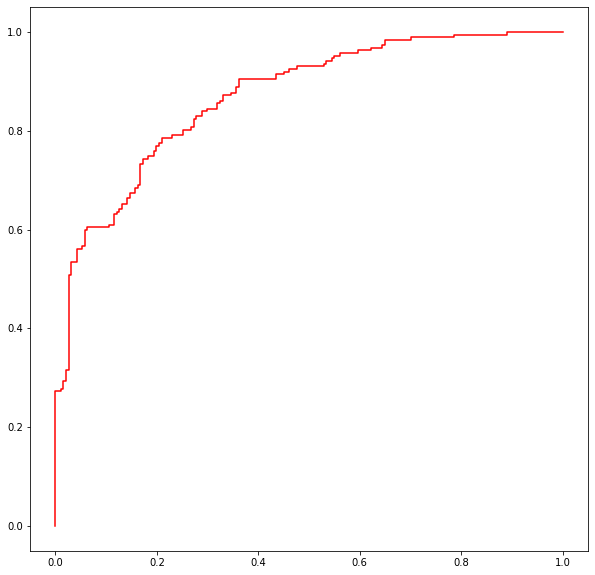

In [ ]:
from collections import Counter
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)


params = {'max_depth': 10,
          'min_child_weight': 6,
          'n_estimators': 1000, 
          'learning_rate': 0.01,
          'lambda': 0.8,
          'alpha': 0.5}
boost2 = xgb.XGBClassifier(**params)#, scale_pos_weight=estimate)

boost2.fit(X_train, y_train)

boost2.proba = boost2.predict_proba(X_test)

boost2.proba = boost2.proba[:,1]

boost2.fpr, boost2.tpr, boost2.thresholds = roc_curve(y_test,boost2.proba)
boost2.auc = auc(boost2.fpr,boost2.tpr)

y_pred=boost2.predict_proba(X_test)[:,1]

print(roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test,boost2.predict(X_test)))
print(accuracy_score(y_test,boost2.predict(X_test)))
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(boost2.fpr,boost2.tpr, color='red', label=f'{boost2}: {boost2.auc}')

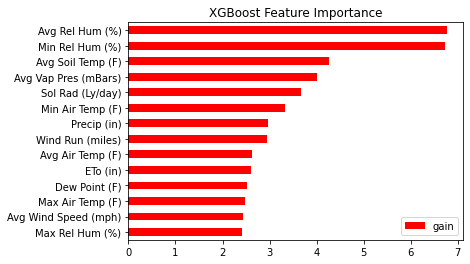

In [ ]:
feature_important = boost2.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["gain"]).sort_values(by ="gain", ascending=True)
data.plot(kind='barh', color='r')
plt.title('XGBoost Feature Importance')
plt.show()

## PREDICTION FEU DE FORET AVEC PREDICTION RNN 

In [91]:
feu_predict=pd.read_csv('drive/My Drive/Projet-ML/Predictions_Bishop.csv')
feu_predict=feu_predict.drop(['Unnamed: 0'],axis=1) 
feu_predict.shape

(25, 14)

In [92]:
df = pd.read_csv('drive/My Drive/Projet-ML/data/df_condition.csv')
df=df.rename(columns={'CIMIS Region':'Region','Stn Name':'Name'})

df=df[df.Name=='Bishop']
df.drop(['Unnamed: 0', 'Stn Id', 'Name','Region'], axis=1, inplace=True)
print(df.shape)
df[df.Target==0]
#df.drop(df.tail(2).index,inplace=True)
#df.tail(20)['Target']

(518, 16)


,Date,ETo (in),Precip (in),Sol Rad (Ly/day),Avg Vap Pres (mBars),Max Air Temp (F),Min Air Temp (F),Avg Air Temp (F),Max Rel Hum (%),Min Rel Hum (%),Avg Rel Hum (%),Dew Point (F),Avg Wind Speed (mph),Wind Run (miles),Avg Soil Temp (F),Target
614,1/1/2018,0.07,0.0,249.0,3.0,66.7,21.9,41.1,67.0,12.0,34.0,15.0,2.3,56.2,42.2,0.0
615,1/2/2018,0.04,0.0,138.0,3.7,61.2,27.5,41.9,64.0,17.0,41.0,19.8,2.2,52.8,42.7,0.0
616,1/3/2018,0.07,0.0,209.0,4.0,63.2,25.4,44.2,72.0,20.0,40.0,21.7,2.4,58.2,43.0,0.0
617,1/4/2018,0.06,0.0,220.0,4.0,63.1,25.4,41.2,73.0,21.0,46.0,21.8,2.6,61.3,43.9,0.0
618,1/5/2018,0.06,0.0,272.0,4.8,63.4,26.0,43.9,80.0,27.0,49.0,26.0,2.3,54.8,43.9,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58828,6/26/2019,0.28,0.0,779.0,7.4,86.4,44.4,68.8,76.0,15.0,31.0,36.7,3.2,76.0,70.8,0.0
58829,6/27/2019,0.27,0.0,780.0,6.3,88.1,39.4,66.7,71.0,14.0,28.0,32.7,2.2,51.8,70.4,0.0
58830,6/28/2019,0.30,0.0,748.0,6.6,87.8,41.8,68.8,78.0,13.0,27.0,33.9,3.7,89.9,70.1,0.0
58831,6/29/2019,0.28,0.0,773.0,7.6,88.3,43.7,69.8,76.0,16.0,30.0,37.3,2.9,69.2,70.6,0.0


In [93]:
X_test=feu_predict
y_test=df.tail(25)['Target'].reset_index(drop=True)
y_test
y_pred=boost2.predict_proba(X_test)[:,1]
#print(roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test,boost2.predict(X_test)))
print(accuracy_score(y_test,boost2.predict(X_test)))

[[25]]
1.0
